# Reproduction of Cycling Task Factor SNN

In [4]:

"""
Library and utility import
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
import zutils
import pandas as pd

In [3]:
"""
Check for GPU availability
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


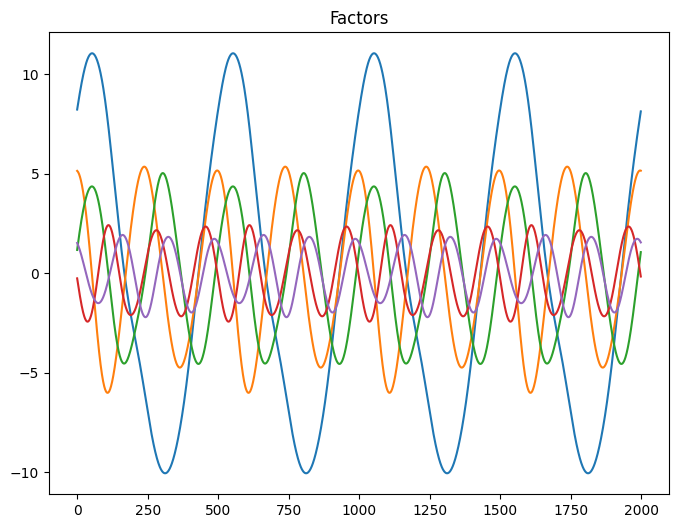

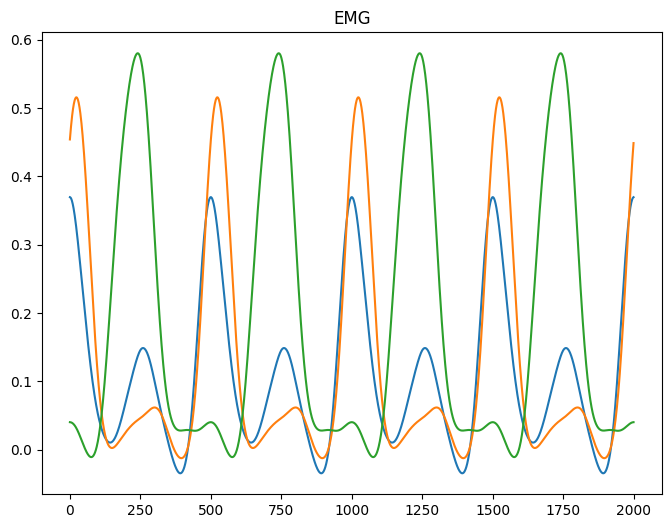

In [497]:
"""
Load in the data and move to device
"""

factors_df = pd.read_csv("./Depaq-Data/Cycling/factors.csv", header=None)
emg_df = pd.read_csv("./Depaq-Data/Cycling/emg.csv", header=None)

factors = torch.tensor(factors_df.values, dtype=torch.float)
emg = torch.tensor(emg_df.values, dtype=torch.float)

factors = factors.to(device)
emg = emg.to(device)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.plot(factors[:,[1,2,3,4,5]])
plt.title("Factors")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(emg[:,[0,1,2]])
plt.title("EMG")
plt.show()

In [498]:
# Generate more training data
n = 5
factors = factors.repeat((n, 1))  # shape (n * 2000, 12)

In [500]:
"""
Define the SNN
"""

# Training parameters
nb_steps  = 9999
batch_size = 1
dtype = torch.float

# Network parameters
nb_inputs  = 1
nb_hidden  = 800
nb_outputs = 12
time_step = 1e-3

tau_mem = 10e-3  # Membrane voltage time constant (10ms)
tau_syn_f = 5e-3  # Synaptic voltage fast time constant (5ms)
tau_syn_s = 100e-3  # Synaptic voltage slow time constant (100ms)

# Decay constants for discretized equations
alpha_f   = float(np.exp(-time_step/tau_syn_f))
alpha_s   = float(np.exp(-time_step/tau_syn_s))
beta    = float(np.exp(-time_step/tau_mem))

# Initialize the network weight matrices
weight_scale = 5.5*(1.0-beta)

# Hidden layer -> Hidden layer (non-factor related)
J_0 = torch.empty((nb_hidden, 2*nb_hidden), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(J_0, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Hidden layer -> Hidden layer (factor related)
U = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(U, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Hidden layer -> factors
W_out = torch.empty((nb_outputs, 2*nb_hidden), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(W_out, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Total recurrent effect: U will be fixed and W_out will be learned to decode the factors
J = J_0 + (U @ W_out)

# Input -> Hidden layer
W_in = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(W_in, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

# Define inputs
inputs = 0.01 * torch.ones((batch_size, nb_inputs, nb_steps), device=device, dtype=dtype, requires_grad=False)
# inputs[:,:,1:50] = 0.1

# Initialize the synaptic and membrane voltages
syn_s = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(syn_s, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

syn_f = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(syn_f, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

syn_total = torch.cat((syn_f, syn_s), dim=1)

mem = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(mem, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [501]:

# Compute the input affects on hidden layer for each time step
h1 = torch.einsum("bit,ih->bht", inputs, W_in)

mem_rec = []
spk_rec = []

P = torch.eye(2*nb_hidden) * 10.0  # Large initial value (λ⁻¹), acts like regularization
factor_pred_rec = []

# Simulate the network
for t in range(9999):
    if t % 1000 == 0:
        print(f"Time step {t}/{nb_steps}")
    out = spike_fn(mem)
    rst = out.detach() # We do not want to backprop through the reset

    # Update synaptic fast a slow voltages
    #           Decay + Input + Spike Increment
    new_syn_f = alpha_f * syn_f + h1[:, :, t] + rst
    new_syn_s = alpha_s * syn_s + h1[:, :, t] + rst
    new_syn_total = torch.cat((new_syn_f, new_syn_s), dim=1)


    # For now, assume batch=1
    x_t = new_syn_total[0]  # shape: (2N,)
    y_t = factors[t]        # shape: (num_factors,)

    # --- RLS UPDATE ---

    if t <=6000:
        Px = P @ x_t
        denom = 1.0 + x_t @ Px
        k_t = Px / denom
        e_t = y_t - W_out @ x_t
        W_out += torch.outer(e_t, k_t)
        P -= torch.outer(k_t, Px)

    factor_pred = new_syn_total @ W_out.T  # shape: (batch_size, num_factors)
    factor_pred_rec.append(factor_pred)


    J_fac = U @ W_out

    # Update the membrane potentials
    #           Decay  +   Nonfactor recurrent + Factor recurrent * Reset
    new_mem = (beta*mem + syn_total @ J_0.T + syn_total @ J_fac.T)*(1.0-rst)

    mem_rec.append(mem)
    spk_rec.append(out)
    
    # Update the state variables
    mem = new_mem
    syn_total = new_syn_total
    syn_f = new_syn_f
    syn_s = new_syn_s

mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)
factor_pred_rec = torch.stack(factor_pred_rec, dim=1)  # shape: (batch_size, time, num_factors)


Time step 0/9999
Time step 1000/9999
Time step 2000/9999
Time step 3000/9999
Time step 4000/9999
Time step 5000/9999
Time step 6000/9999
Time step 7000/9999
Time step 8000/9999
Time step 9000/9999


In [455]:
factor_pred_rec.size()

torch.Size([1, 1000, 12])

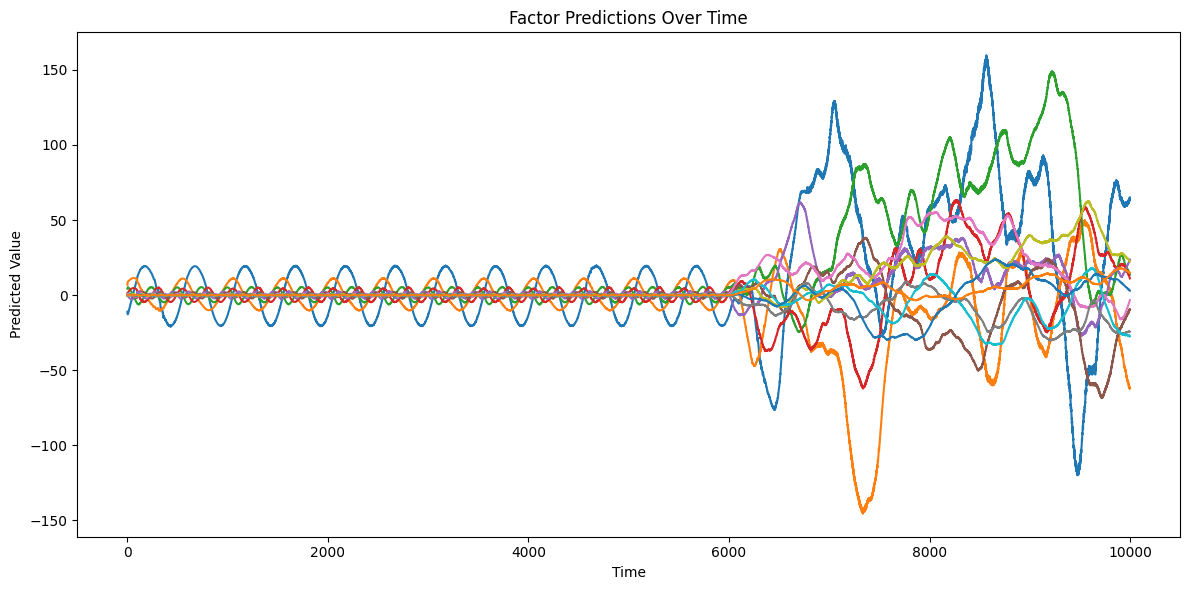

In [502]:
import matplotlib.pyplot as plt

# Remove batch dimension: (1, 1000, 12) -> (1000, 12)
factor_pred_np = factor_pred_rec.squeeze(0).detach().cpu().numpy()

# Plot each factor over time
plt.figure(figsize=(12, 6))
for i in range(factor_pred_np.shape[1]):  # loop over 12 factors
    plt.plot(factor_pred_np[:, i], label=f'Factor {i+1}')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Factor Predictions Over Time')
plt.tight_layout()
plt.show()

In [503]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)
plt.title("Hidden layer activity of Untrained SNN")
plt.ylabel("Membrane potential (AU)")
plt.xlabel("Time (ms)")
plt.show()

KeyboardInterrupt: 

In [297]:
def plot_voltage_traces(mem, spk=None, dim=(1,1), spike_height=40):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        # ax.axis("off")

    ax.set_ylim(-50, 50)

In [215]:
# Define the heaviside step function for the nonlinearity
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 10] = 1.0
    return out